In [1]:
import os, sklearn, pandas, numpy as np
from sklearn import svm
import skimage, skimage.io, skimage.filters
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# set cwd back to default
os.chdir('../')

In [3]:
## NN libs
import keras
from keras.layers import Dense, Activation
from keras.utils import to_categorical
from keras.optimizers import SGD, Adam
from keras.layers import Input, Conv2D, Conv2DTranspose, Dense, Reshape, MaxPooling2D, UpSampling2D, Flatten
from keras.models import Model

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
# custom scripts
import config # params, constants
import data, models # functions that mutate outr data
from utils import utils, plot # custom functions, in local environment

 Dataset :: namedtuple(
    ['train' = ['img_name']
    , 'test' = ['img_name']
    , 'validation' = ['img_name']
    , 'labels' = pandas.df('img_name','label')
    , 'dict_index_to_label' = dict to convert label_index -> label_name
    , 'dict_label_to_index'= dict to convert label_name -> label_index
    


# Prepare dataset
amt should be either 50, 100, 150, 200 etc...

In [8]:
def gen_labels_random(amt_labels, amt_classes=9):
    return [int((np.random.random() * amt_classes) ) for _ in range(amt_labels)]

def gen_labels(amt_labels, amt_classes=9):
    # beware of a large number of classes
    return [ int(x_train[i].mean() * 10) for i in range(x_train.shape[0]) ]

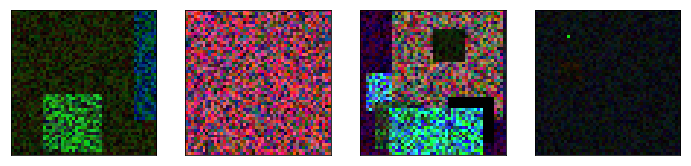

In [10]:
# plot.multiple(x_train)

### Prepare the labels

Encode the labels to one-hot vectors

In [11]:
# # int-labels => one-hot vectors
# y_train = to_categorical(y_train)
# y_test = to_categorical(y_test)

# print('n labels:',y_train[0].shape)
# print(y_train.shape)
# y_train[0]

n labels: (4,)
(4, 4)


array([0., 1., 0., 0.])

## Setup decoder

In [305]:
input_length = 2
input_shape = (input_length,)
w = 100 # width of the network
k_init = 'glorot_normal' # random_uniform glorot_normal
b_init = 'glorot_normal'

In [320]:
input_ = Input(shape=input_shape)
x = Dense(w, activation='relu')(input_) # (None, 128)
for i in range(10):
    x = Dense(w, activation='relu', kernel_initializer=k_init, bias_initializer=b_init)(x) # (None, 128)
# for i in range(10):
# x = Reshape(x)
# x = keras.layers.UpSampling1D(())(x)
    #     x = Conv2D(3, (3, 3), activation='relu')(x)


# x = Reshape((4,4,8))(x) # (None, 4, 4, 8)  
# x = UpSampling2D((8, 8))(x) # (None, 32, 32, 8)
# x = Conv2D(4, (8, 8), activation='relu')(x) # (None, 25, 25, 4)
# x = UpSampling2D((2, 2))(x) # (None, 100, 100, 4)
# x = Conv2D(3, (1, 1), activation='relu')(x) # (None, 50, 50, 3) 

n_colors = 3
output_w = 300
output_h = 200
n_outputs = output_h * output_w * n_colors
output_shape = (output_h, output_w, n_colors)
# print('output_shape:', output_shape)
# resized = Dense(n_outputs, activation='sigmoid')(x)
# x = Reshape(output_shape)(resized)
x = Dense(2,activation='sigmoid')(x)

decoder = Model(input_, x)
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_75 (InputLayer)        (None, 2)                 0         
_________________________________________________________________
dense_327 (Dense)            (None, 100)               300       
_________________________________________________________________
dense_328 (Dense)            (None, 100)               10100     
_________________________________________________________________
dense_329 (Dense)            (None, 100)               10100     
_________________________________________________________________
dense_330 (Dense)            (None, 100)               10100     
_________________________________________________________________
dense_331 (Dense)            (None, 100)               10100     
_________________________________________________________________
dense_332 (Dense)            (None, 100)               10100     
__________

In [321]:
decoder.compile(optimizer='adam', loss='categorical_crossentropy')

In [322]:
n = 1000 * 100
x_test = np.random.random([n,input_length])
# samples = np.stack([sample])
y_test = decoder.predict(x_test)

In [323]:
print(y_test.shape)
print(y_test.max(), y_test.min())

(100000, 2)
0.57221144 0.47098312


In [324]:
maxx = y_test.max()
minn = y_test.min()
normalized = (y_test.copy() - minn) / (maxx - minn)

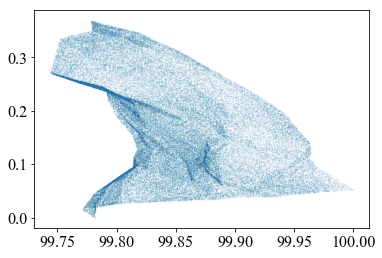

In [327]:
a = 100
# result = y_test
result = normalized
plt.scatter(result[:,0] * a,result[:,1] * a, alpha=0.1, s=0.1)

In [299]:
# plt.savefig('../plots/gan.png', bbox_inches='tight')

In [300]:
normalized.mean()

0.5

In [183]:
# selection = y_test[:3,:,:,:] # n, h, w, rgb
# plot.multiple(selection * 255)

TypeError: Invalid dimensions for image data

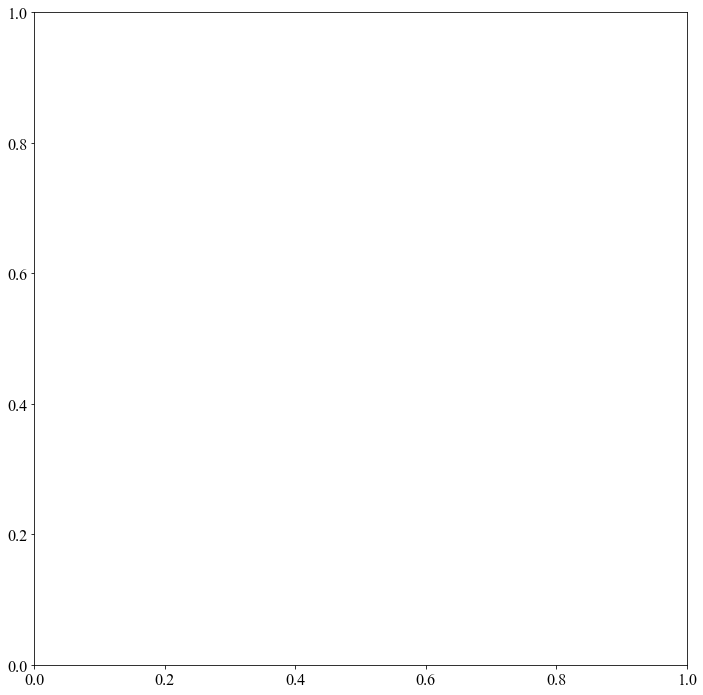

In [181]:
mean = y_test.mean(axis=0)
plot.multiple([mean * 255])

In [138]:
a = np.array([[[0,0,1]] for x in range(4)])

In [139]:
a.mean(axis=(0,))

array([[0., 0., 1.]])

## Auto-encoder

In [17]:
auto = Model(input_, decoder(encoder(input_)))
auto.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 50, 50, 3)         0         
_________________________________________________________________
model_1 (Model)              (None, 2)                 4266      
_________________________________________________________________
model_2 (Model)              (None, 50, 50, 3)         2535      
Total params: 6,801
Trainable params: 6,801
Non-trainable params: 0
_________________________________________________________________


### Loss function
Train with binary cross-entropy (each pixel is seen as a probability).

Training data (pixel values) must be normalized to [0:1]

In [18]:
auto.compile(optimizer='adam', loss='binary_crossentropy')

## Train model

In [19]:
# Compute a batch size
batch_size = 128
# n epochs = n iterations over all the training data
epochs = 900

In [20]:
x_train.shape

(4, 50, 50, 3)

In [21]:
# no validation is needed for the autoencoder, as the goal is to reconstruct the data as good as possible
auto.fit(x_train, x_train, epochs=epochs, batch_size=batch_size)

Epoch 1/900
4/4 [==============================] - 1s 242ms/step - loss: 0.6937
Epoch 2/900
4/4 [==============================] - 0s 9ms/step - loss: 0.6931
Epoch 3/900
4/4 [==============================] - 0s 8ms/step - loss: 0.6926
Epoch 4/900
4/4 [==============================] - 0s 9ms/step - loss: 0.6921
Epoch 5/900
4/4 [==============================] - 0s 8ms/step - loss: 0.6917
Epoch 6/900
4/4 [==============================] - 0s 8ms/step - loss: 0.6913
Epoch 7/900
4/4 [==============================] - 0s 7ms/step - loss: 0.6909
Epoch 8/900
4/4 [==============================] - 0s 6ms/step - loss: 0.6905
Epoch 9/900
4/4 [==============================] - 0s 8ms/step - loss: 0.6901
Epoch 10/900
4/4 [==============================] - 0s 7ms/step - loss: 0.6896
Epoch 11/900
4/4 [==============================] - 0s 7ms/step - loss: 0.6892
Epoch 12/900
4/4 [==============================] - 0s 7ms/step - loss: 0.6888
Epoch 13/900
4/4 [==============================] - 0s 6ms/

Epoch 105/900
4/4 [==============================] - 0s 7ms/step - loss: 0.4587
Epoch 106/900
4/4 [==============================] - 0s 7ms/step - loss: 0.4586
Epoch 107/900
4/4 [==============================] - 0s 6ms/step - loss: 0.4586
Epoch 108/900
4/4 [==============================] - 0s 7ms/step - loss: 0.4585
Epoch 109/900
4/4 [==============================] - 0s 6ms/step - loss: 0.4584
Epoch 110/900
4/4 [==============================] - 0s 6ms/step - loss: 0.4583
Epoch 111/900
4/4 [==============================] - 0s 6ms/step - loss: 0.4582
Epoch 112/900
4/4 [==============================] - 0s 7ms/step - loss: 0.4581
Epoch 113/900
4/4 [==============================] - 0s 7ms/step - loss: 0.4581
Epoch 114/900
4/4 [==============================] - 0s 7ms/step - loss: 0.4580
Epoch 115/900
4/4 [==============================] - 0s 6ms/step - loss: 0.4579
Epoch 116/900
4/4 [==============================] - 0s 6ms/step - loss: 0.4578
Epoch 117/900
4/4 [=====================

Epoch 208/900
4/4 [==============================] - 0s 7ms/step - loss: 0.4472
Epoch 209/900
4/4 [==============================] - 0s 7ms/step - loss: 0.4472
Epoch 210/900
4/4 [==============================] - 0s 7ms/step - loss: 0.4471
Epoch 211/900
4/4 [==============================] - 0s 7ms/step - loss: 0.4469
Epoch 212/900
4/4 [==============================] - 0s 6ms/step - loss: 0.4469
Epoch 213/900
4/4 [==============================] - 0s 6ms/step - loss: 0.4468
Epoch 214/900
4/4 [==============================] - 0s 8ms/step - loss: 0.4466
Epoch 215/900
4/4 [==============================] - 0s 7ms/step - loss: 0.4466
Epoch 216/900
4/4 [==============================] - 0s 6ms/step - loss: 0.4465
Epoch 217/900
4/4 [==============================] - 0s 7ms/step - loss: 0.4464
Epoch 218/900
4/4 [==============================] - 0s 7ms/step - loss: 0.4463
Epoch 219/900
4/4 [==============================] - 0s 6ms/step - loss: 0.4462
Epoch 220/900
4/4 [=====================

Epoch 311/900
4/4 [==============================] - 0s 6ms/step - loss: 0.4397
Epoch 312/900
4/4 [==============================] - 0s 6ms/step - loss: 0.4397
Epoch 313/900
4/4 [==============================] - 0s 6ms/step - loss: 0.4396
Epoch 314/900
4/4 [==============================] - 0s 6ms/step - loss: 0.4396
Epoch 315/900
4/4 [==============================] - 0s 6ms/step - loss: 0.4395
Epoch 316/900
4/4 [==============================] - 0s 6ms/step - loss: 0.4395
Epoch 317/900
4/4 [==============================] - 0s 6ms/step - loss: 0.4394
Epoch 318/900
4/4 [==============================] - 0s 6ms/step - loss: 0.4394
Epoch 319/900
4/4 [==============================] - 0s 6ms/step - loss: 0.4393
Epoch 320/900
4/4 [==============================] - 0s 6ms/step - loss: 0.4393
Epoch 321/900
4/4 [==============================] - 0s 6ms/step - loss: 0.4392
Epoch 322/900
4/4 [==============================] - 0s 6ms/step - loss: 0.4391
Epoch 323/900
4/4 [=====================

Epoch 414/900
4/4 [==============================] - 0s 6ms/step - loss: 0.4341
Epoch 415/900
4/4 [==============================] - 0s 7ms/step - loss: 0.4341
Epoch 416/900
4/4 [==============================] - 0s 6ms/step - loss: 0.4340
Epoch 417/900
4/4 [==============================] - 0s 7ms/step - loss: 0.4340
Epoch 418/900
4/4 [==============================] - 0s 6ms/step - loss: 0.4339
Epoch 419/900
4/4 [==============================] - 0s 6ms/step - loss: 0.4339
Epoch 420/900
4/4 [==============================] - 0s 6ms/step - loss: 0.4338
Epoch 421/900
4/4 [==============================] - 0s 7ms/step - loss: 0.4338
Epoch 422/900
4/4 [==============================] - 0s 7ms/step - loss: 0.4337
Epoch 423/900
4/4 [==============================] - 0s 6ms/step - loss: 0.4337
Epoch 424/900
4/4 [==============================] - 0s 7ms/step - loss: 0.4336
Epoch 425/900
4/4 [==============================] - 0s 7ms/step - loss: 0.4335
Epoch 426/900
4/4 [=====================

Epoch 517/900
4/4 [==============================] - 0s 6ms/step - loss: 0.4306
Epoch 518/900
4/4 [==============================] - 0s 8ms/step - loss: 0.4306
Epoch 519/900
4/4 [==============================] - 0s 6ms/step - loss: 0.4306
Epoch 520/900
4/4 [==============================] - 0s 6ms/step - loss: 0.4306
Epoch 521/900
4/4 [==============================] - 0s 7ms/step - loss: 0.4306
Epoch 522/900
4/4 [==============================] - 0s 6ms/step - loss: 0.4305
Epoch 523/900
4/4 [==============================] - 0s 6ms/step - loss: 0.4305
Epoch 524/900
4/4 [==============================] - 0s 6ms/step - loss: 0.4305
Epoch 525/900
4/4 [==============================] - 0s 7ms/step - loss: 0.4305
Epoch 526/900
4/4 [==============================] - 0s 8ms/step - loss: 0.4305
Epoch 527/900
4/4 [==============================] - 0s 7ms/step - loss: 0.4305
Epoch 528/900
4/4 [==============================] - 0s 6ms/step - loss: 0.4305
Epoch 529/900
4/4 [=====================

Epoch 620/900
4/4 [==============================] - 0s 8ms/step - loss: 0.4292
Epoch 621/900
4/4 [==============================] - 0s 8ms/step - loss: 0.4292
Epoch 622/900
4/4 [==============================] - 0s 8ms/step - loss: 0.4292
Epoch 623/900
4/4 [==============================] - 0s 8ms/step - loss: 0.4292
Epoch 624/900
4/4 [==============================] - 0s 8ms/step - loss: 0.4292
Epoch 625/900
4/4 [==============================] - 0s 8ms/step - loss: 0.4292
Epoch 626/900
4/4 [==============================] - 0s 8ms/step - loss: 0.4291
Epoch 627/900
4/4 [==============================] - 0s 7ms/step - loss: 0.4291
Epoch 628/900
4/4 [==============================] - 0s 7ms/step - loss: 0.4290
Epoch 629/900
4/4 [==============================] - 0s 7ms/step - loss: 0.4290
Epoch 630/900
4/4 [==============================] - 0s 7ms/step - loss: 0.4290
Epoch 631/900
4/4 [==============================] - 0s 8ms/step - loss: 0.4290
Epoch 632/900
4/4 [=====================

Epoch 723/900
4/4 [==============================] - 0s 7ms/step - loss: 0.4281
Epoch 724/900
4/4 [==============================] - 0s 6ms/step - loss: 0.4282
Epoch 725/900
4/4 [==============================] - 0s 7ms/step - loss: 0.4283
Epoch 726/900
4/4 [==============================] - 0s 7ms/step - loss: 0.4282
Epoch 727/900
4/4 [==============================] - 0s 5ms/step - loss: 0.4280
Epoch 728/900
4/4 [==============================] - 0s 6ms/step - loss: 0.4281
Epoch 729/900
4/4 [==============================] - 0s 7ms/step - loss: 0.4282
Epoch 730/900
4/4 [==============================] - 0s 8ms/step - loss: 0.4281
Epoch 731/900
4/4 [==============================] - 0s 6ms/step - loss: 0.4280
Epoch 732/900
4/4 [==============================] - 0s 8ms/step - loss: 0.4280
Epoch 733/900
4/4 [==============================] - 0s 6ms/step - loss: 0.4281
Epoch 734/900
4/4 [==============================] - 0s 5ms/step - loss: 0.4281
Epoch 735/900
4/4 [=====================

Epoch 826/900
4/4 [==============================] - 0s 7ms/step - loss: 0.4273
Epoch 827/900
4/4 [==============================] - 0s 7ms/step - loss: 0.4273
Epoch 828/900
4/4 [==============================] - 0s 8ms/step - loss: 0.4273
Epoch 829/900
4/4 [==============================] - 0s 8ms/step - loss: 0.4273
Epoch 830/900
4/4 [==============================] - 0s 8ms/step - loss: 0.4273
Epoch 831/900
4/4 [==============================] - 0s 7ms/step - loss: 0.4273
Epoch 832/900
4/4 [==============================] - 0s 6ms/step - loss: 0.4273
Epoch 833/900
4/4 [==============================] - 0s 8ms/step - loss: 0.4273
Epoch 834/900
4/4 [==============================] - 0s 8ms/step - loss: 0.4274
Epoch 835/900
4/4 [==============================] - 0s 8ms/step - loss: 0.4274
Epoch 836/900
4/4 [==============================] - 0s 7ms/step - loss: 0.4274
Epoch 837/900
4/4 [==============================] - 0s 8ms/step - loss: 0.4274
Epoch 838/900
4/4 [=====================

## Generate new images

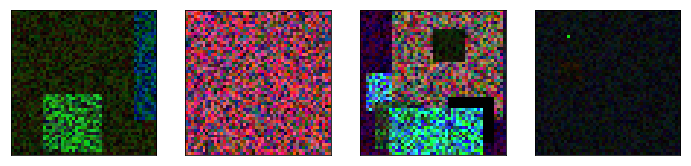

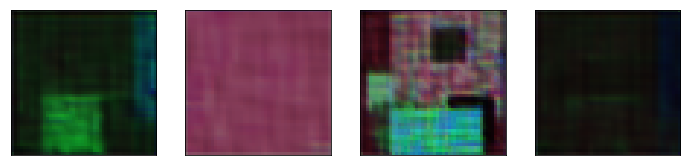

In [22]:
# old data
inputs1 = x_train[:10, :, :, :]
outputs1 = auto.predict(inputs1)

plot.multiple(inputs1[:10])
plot.multiple(outputs1[:10])

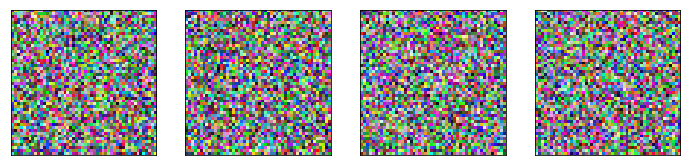

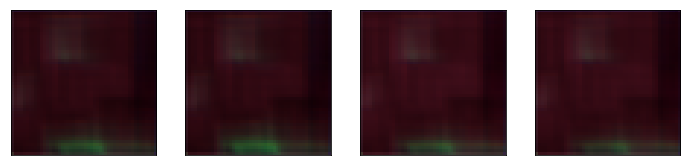

In [23]:
# new data
inputs = x_test[:10, :, :, :]
outputs = auto.predict(inputs)

plot.multiple(inputs[:10])
plot.multiple(outputs[:10])

In [24]:
# investigate the range of the 'hidden' layer
inputs2 = x_test[:10, :, :, :]
outputs2 = encoder.predict(inputs2)
print(outputs2)

[[ 0.60537726 -1.2021903 ]
 [ 0.56978273 -1.2507943 ]
 [ 0.5025147  -0.9977456 ]
 [ 0.5680617  -0.97980565]]


Use random values as input for the decoder

10 [[0.17823865170851827, 2.295595226764515], [91.63330538159684, 11.577029161407939], [45.90177458419863, 0.17349831935221596], [11.102294942359551, 26.784855659457296], [34.98197360490001, 48.66111423203185], [37.44619534752127, 20.033676750197717], [80.33517865782385, 4.782579054021228], [44.46348548436439, 94.75404825773174], [26.644156969108106, 0.961067607153381], [13.894352801113548, 72.2395448898638]]


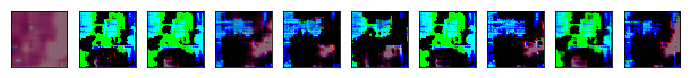

In [25]:
# samples = np.array([ [3,1.8] ])
def random(scale=100):
    # :scale = random value in range [-scale:scale]
    # use ** 2 to skew the distribution
    return scale * ((np.random.random() - 0.5) * 2) ** 2

samples = []
for x in range(10):
    # sample = np.random.random([hidden_size]) * scale * ((np.random.random() - 0.5) * 2) ** 2
    sample = [random() for _ in range(hidden_size)]
    samples.append(sample)

print(len(samples), samples)
samples = np.stack(samples)
results = decoder.predict(samples)
plot.multiple(results)

Note that high values produce complex results

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


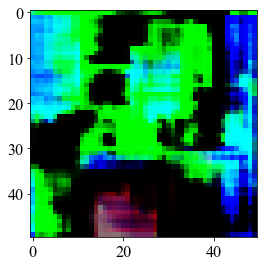

In [26]:
skimage.io.imshow(results[8])

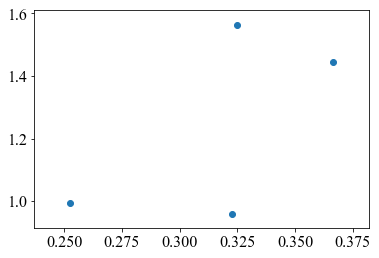

In [27]:
num = 10

inputs3 = x_test[:num, :, :, :]
latent = encoder.predict(inputs3) ** 2

# plt.scatter(latent[:,0], latent[:,1], c=y_test[:num], alpha=0.1)
plt.scatter(latent[:,0],latent[:,1])

## Retrain (recursively)

In [38]:
epochs = 10
for _ in range(10):
    x_result = auto.predict(x_train)
    auto.fit(x_result, x_result, epochs=epochs, batch_size=batch_size);
    x_result = auto.predict(x_result)

Epoch 1/100
3/3 [==============================] - 0s 12ms/step - loss: 0.3984
Epoch 2/100
3/3 [==============================] - 0s 12ms/step - loss: 0.3910
Epoch 3/100
3/3 [==============================] - 0s 13ms/step - loss: 0.4058
Epoch 4/100
3/3 [==============================] - 0s 13ms/step - loss: 0.3900
Epoch 5/100
3/3 [==============================] - 0s 10ms/step - loss: 0.3945
Epoch 6/100
3/3 [==============================] - 0s 11ms/step - loss: 0.3922
Epoch 7/100
3/3 [==============================] - 0s 12ms/step - loss: 0.3879
Epoch 8/100
3/3 [==============================] - 0s 12ms/step - loss: 0.3824
Epoch 9/100
3/3 [==============================] - 0s 12ms/step - loss: 0.3840
Epoch 10/100
3/3 [==============================] - 0s 12ms/step - loss: 0.3831
Epoch 11/100
3/3 [==============================] - 0s 15ms/step - loss: 0.3781
Epoch 12/100
3/3 [==============================] - 0s 15ms/step - loss: 0.3799
Epoch 13/100
3/3 [==============================]

Epoch 4/100
3/3 [==============================] - 0s 8ms/step - loss: 0.3129
Epoch 5/100
3/3 [==============================] - 0s 10ms/step - loss: 0.3141
Epoch 6/100
3/3 [==============================] - 0s 8ms/step - loss: 0.3091
Epoch 7/100
3/3 [==============================] - 0s 10ms/step - loss: 0.3101
Epoch 8/100
3/3 [==============================] - 0s 8ms/step - loss: 0.3097
Epoch 9/100
3/3 [==============================] - 0s 10ms/step - loss: 0.3096
Epoch 10/100
3/3 [==============================] - 0s 9ms/step - loss: 0.3080
Epoch 11/100
3/3 [==============================] - 0s 8ms/step - loss: 0.3071
Epoch 12/100
3/3 [==============================] - 0s 8ms/step - loss: 0.3083
Epoch 13/100
3/3 [==============================] - 0s 7ms/step - loss: 0.3069
Epoch 14/100
3/3 [==============================] - 0s 9ms/step - loss: 0.3063
Epoch 15/100
3/3 [==============================] - 0s 9ms/step - loss: 0.3057
Epoch 16/100
3/3 [==============================] - 0s 

Epoch 8/100
3/3 [==============================] - 0s 9ms/step - loss: 0.2617
Epoch 9/100
3/3 [==============================] - 0s 8ms/step - loss: 0.2655
Epoch 10/100
3/3 [==============================] - 0s 9ms/step - loss: 0.2614
Epoch 11/100
3/3 [==============================] - 0s 7ms/step - loss: 0.2630
Epoch 12/100
3/3 [==============================] - 0s 10ms/step - loss: 0.2612
Epoch 13/100
3/3 [==============================] - 0s 9ms/step - loss: 0.2617
Epoch 14/100
3/3 [==============================] - 0s 8ms/step - loss: 0.2608
Epoch 15/100
3/3 [==============================] - 0s 8ms/step - loss: 0.2602
Epoch 16/100
3/3 [==============================] - 0s 12ms/step - loss: 0.2603
Epoch 17/100
3/3 [==============================] - 0s 7ms/step - loss: 0.2604
Epoch 18/100
3/3 [==============================] - 0s 10ms/step - loss: 0.2601
Epoch 19/100
3/3 [==============================] - 0s 8ms/step - loss: 0.2595
Epoch 20/100
3/3 [==============================] -

Epoch 12/100
3/3 [==============================] - 0s 9ms/step - loss: 0.2351
Epoch 13/100
3/3 [==============================] - 0s 9ms/step - loss: 0.2350
Epoch 14/100
3/3 [==============================] - 0s 7ms/step - loss: 0.2342
Epoch 15/100
3/3 [==============================] - 0s 8ms/step - loss: 0.2347
Epoch 16/100
3/3 [==============================] - 0s 8ms/step - loss: 0.2340
Epoch 17/100
3/3 [==============================] - 0s 8ms/step - loss: 0.2341
Epoch 18/100
3/3 [==============================] - 0s 11ms/step - loss: 0.2339
Epoch 19/100
3/3 [==============================] - 0s 8ms/step - loss: 0.2338
Epoch 20/100
3/3 [==============================] - 0s 9ms/step - loss: 0.2335
Epoch 21/100
3/3 [==============================] - 0s 7ms/step - loss: 0.2335
Epoch 22/100
3/3 [==============================] - 0s 7ms/step - loss: 0.2335
Epoch 23/100
3/3 [==============================] - 0s 8ms/step - loss: 0.2332
Epoch 24/100
3/3 [==============================] -

Epoch 16/100
3/3 [==============================] - 0s 11ms/step - loss: 0.2190
Epoch 17/100
3/3 [==============================] - 0s 16ms/step - loss: 0.2186
Epoch 18/100
3/3 [==============================] - 0s 16ms/step - loss: 0.2190
Epoch 19/100
3/3 [==============================] - 0s 12ms/step - loss: 0.2186
Epoch 20/100
3/3 [==============================] - 0s 9ms/step - loss: 0.2188
Epoch 21/100
3/3 [==============================] - 0s 13ms/step - loss: 0.2187
Epoch 22/100
3/3 [==============================] - 0s 10ms/step - loss: 0.2186
Epoch 23/100
3/3 [==============================] - 0s 9ms/step - loss: 0.2187
Epoch 24/100
3/3 [==============================] - 0s 9ms/step - loss: 0.2185
Epoch 25/100
3/3 [==============================] - 0s 9ms/step - loss: 0.2187
Epoch 26/100
3/3 [==============================] - 0s 8ms/step - loss: 0.2185
Epoch 27/100
3/3 [==============================] - 0s 10ms/step - loss: 0.2186
Epoch 28/100
3/3 [===========================

3/3 [==============================] - 0s 12ms/step - loss: 0.2094
Epoch 20/100
3/3 [==============================] - 0s 8ms/step - loss: 0.2095
Epoch 21/100
3/3 [==============================] - 0s 8ms/step - loss: 0.2094
Epoch 22/100
3/3 [==============================] - 0s 8ms/step - loss: 0.2094
Epoch 23/100
3/3 [==============================] - 0s 9ms/step - loss: 0.2094
Epoch 24/100
3/3 [==============================] - 0s 8ms/step - loss: 0.2093
Epoch 25/100
3/3 [==============================] - 0s 7ms/step - loss: 0.2094
Epoch 26/100
3/3 [==============================] - 0s 9ms/step - loss: 0.2094
Epoch 27/100
3/3 [==============================] - 0s 8ms/step - loss: 0.2093
Epoch 28/100
3/3 [==============================] - 0s 11ms/step - loss: 0.2094
Epoch 29/100
3/3 [==============================] - 0s 9ms/step - loss: 0.2093
Epoch 30/100
3/3 [==============================] - 0s 11ms/step - loss: 0.2093
Epoch 31/100
3/3 [==============================] - 0s 9ms/ste

Epoch 23/100
3/3 [==============================] - 0s 7ms/step - loss: 0.2048
Epoch 24/100
3/3 [==============================] - 0s 11ms/step - loss: 0.2048
Epoch 25/100
3/3 [==============================] - 0s 10ms/step - loss: 0.2048
Epoch 26/100
3/3 [==============================] - 0s 11ms/step - loss: 0.2048
Epoch 27/100
3/3 [==============================] - 0s 7ms/step - loss: 0.2048
Epoch 28/100
3/3 [==============================] - 0s 12ms/step - loss: 0.2048
Epoch 29/100
3/3 [==============================] - 0s 9ms/step - loss: 0.2048
Epoch 30/100
3/3 [==============================] - 0s 11ms/step - loss: 0.2048
Epoch 31/100
3/3 [==============================] - 0s 9ms/step - loss: 0.2048
Epoch 32/100
3/3 [==============================] - 0s 11ms/step - loss: 0.2047
Epoch 33/100
3/3 [==============================] - 0s 12ms/step - loss: 0.2048
Epoch 34/100
3/3 [==============================] - 0s 8ms/step - loss: 0.2048
Epoch 35/100
3/3 [===========================

Epoch 27/100
3/3 [==============================] - 0s 8ms/step - loss: 0.2010
Epoch 28/100
3/3 [==============================] - 0s 8ms/step - loss: 0.2010
Epoch 29/100
3/3 [==============================] - 0s 8ms/step - loss: 0.2010
Epoch 30/100
3/3 [==============================] - 0s 8ms/step - loss: 0.2010
Epoch 31/100
3/3 [==============================] - 0s 8ms/step - loss: 0.2010
Epoch 32/100
3/3 [==============================] - 0s 7ms/step - loss: 0.2010
Epoch 33/100
3/3 [==============================] - 0s 9ms/step - loss: 0.2010
Epoch 34/100
3/3 [==============================] - 0s 7ms/step - loss: 0.2010
Epoch 35/100
3/3 [==============================] - 0s 9ms/step - loss: 0.2010
Epoch 36/100
3/3 [==============================] - 0s 7ms/step - loss: 0.2010
Epoch 37/100
3/3 [==============================] - 0s 8ms/step - loss: 0.2010
Epoch 38/100
3/3 [==============================] - 0s 7ms/step - loss: 0.2010
Epoch 39/100
3/3 [==============================] - 

Epoch 31/100
3/3 [==============================] - 0s 10ms/step - loss: 0.1983
Epoch 32/100
3/3 [==============================] - 0s 7ms/step - loss: 0.1983
Epoch 33/100
3/3 [==============================] - 0s 11ms/step - loss: 0.1983
Epoch 34/100
3/3 [==============================] - 0s 10ms/step - loss: 0.1983
Epoch 35/100
3/3 [==============================] - 0s 11ms/step - loss: 0.1983
Epoch 36/100
3/3 [==============================] - 0s 7ms/step - loss: 0.1983
Epoch 37/100
3/3 [==============================] - 0s 11ms/step - loss: 0.1983
Epoch 38/100
3/3 [==============================] - 0s 10ms/step - loss: 0.1983
Epoch 39/100
3/3 [==============================] - 0s 9ms/step - loss: 0.1983
Epoch 40/100
3/3 [==============================] - 0s 10ms/step - loss: 0.1983
Epoch 41/100
3/3 [==============================] - 0s 10ms/step - loss: 0.1983
Epoch 42/100
3/3 [==============================] - 0s 11ms/step - loss: 0.1983
Epoch 43/100
3/3 [=========================

Epoch 34/100
3/3 [==============================] - 0s 9ms/step - loss: 0.1962
Epoch 35/100
3/3 [==============================] - 0s 8ms/step - loss: 0.1962
Epoch 36/100
3/3 [==============================] - 0s 11ms/step - loss: 0.1962
Epoch 37/100
3/3 [==============================] - 0s 8ms/step - loss: 0.1963
Epoch 38/100
3/3 [==============================] - 0s 12ms/step - loss: 0.1963
Epoch 39/100
3/3 [==============================] - 0s 12ms/step - loss: 0.1963
Epoch 40/100
3/3 [==============================] - 0s 9ms/step - loss: 0.1962
Epoch 41/100
3/3 [==============================] - 0s 7ms/step - loss: 0.1962
Epoch 42/100
3/3 [==============================] - 0s 10ms/step - loss: 0.1962
Epoch 43/100
3/3 [==============================] - 0s 8ms/step - loss: 0.1962
Epoch 44/100
3/3 [==============================] - 0s 10ms/step - loss: 0.1962
Epoch 45/100
3/3 [==============================] - 0s 9ms/step - loss: 0.1962
Epoch 46/100
3/3 [=============================

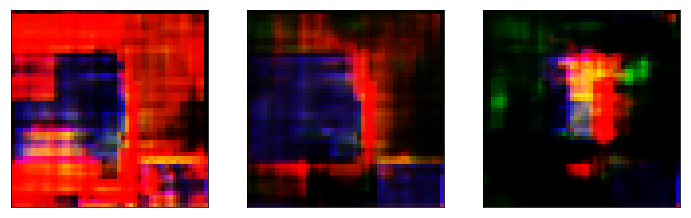

In [39]:
plot.multiple(x_result[:10])

10 [[32.961209169334985, 0.4099600711197713], [67.72741148292265, 83.13994506710472], [39.98837238312, 29.079484675599915], [75.90560984165539, 16.867891552968846], [5.143906928606077, 29.748362380667043], [98.45859974646565, 1.2782906342241747], [0.34689847356824455, 2.4028599262781296], [93.15322327767032, 75.05367879480019], [2.8792125251808693, 7.36588943588459], [23.359888298034434, 6.626756723774624]]


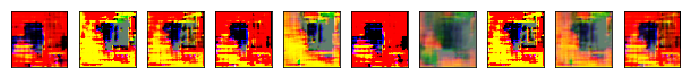

In [42]:
# with random data

samples = []
for x in range(10):
    # sample = np.random.random([hidden_size]) * scale * ((np.random.random() - 0.5) * 2) ** 2
    sample = [random() for _ in range(hidden_size)]
    samples.append(sample)

samples = np.stack(samples)
results = decoder.predict(samples)
plot.multiple(results)